# Hydrological Modeling using GEE and LSTM

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/biplovbhandari/tensorflow-ml-models/blob/master/Hydrological_Modeling_using_GEE_and_LSTM.ipynb)

Welcome to this tutorial! In this notebook, we will walk you through a step-by-step example of accessing observed and forcing data for hydrologic modeling. We will also demonstrate how to train a powerful Long-Short-Term Memory (LSTM) model to simulate streamflow. To do this, we will leverage the capabilities of Google Earth Engine (GEE) to access meteorological data as inputs for our model.

Our example is inspired by the following paper: ["Rainfall-runoff modelling using Long Short-Term Memory (LSTM) networks"](https://www.hydrol-earth-syst-sci.net/22/6005/2018/). Let"s dive in and get started with the exciting world of hydrologic modeling and LSTM networks! The notebook is developed by Kel Markert and Biplov Bhandari.

## Setting up the environment

### Importing packages

In this tutorial, we will employ the Pandas library to effectively manage our time series data, which will be utilized to train our model. Additionally, we will utilize HTTP request and IO packages to retrieve data from the USGS API, enabling us to work with a rich source of information for our training process.

In [ ]:
%pylab inline

import pandas as pd
import requests
from io import StringIO

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# Import, authenticate and initialize the Earth Engine library.
import ee
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=lvlDJYtif-0oBFz0g7c29k0sgZa8Q_ro3hCB4T7yo7M&tc=LkQEJhC__SnHkQ0Edc3RVwx-rHp0NZwjGo7ee6UOHdM&cc=h8nlYzF5dehxYvmhouwmq8W6ySkyoQmS9UP9tuVxwfc

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1Adeu5BU2y0Jx0a95AyKqpQ8Ypw2jRwDXwH5jiujd3DFo5AXMLdU_emGgAVY

Successfully saved authorization token.


In [ ]:
# Tensorflow setup.
import tensorflow as tf
from tensorflow import keras
from keras import models
from keras import optimizers
from keras import layers
from keras import callbacks
from keras import backend as K

# used to help transform data
from sklearn import preprocessing

print(f"Using TensorFlow version {tf.__version__}")

Using TensorFlow version 2.12.0


In [ ]:
# for visualization
import folium

## Accessing data

To proceed with this example, we will require two crucial datasets:

1. **Observed streamflow**: Acquiring this data may pose challenges depending upon where you are located. Fortunately, in the US, the USGS offers a website (https://waterdata.usgs.gov/nwis) that allows users to search and programmatically access gauge data.

2. **Meteorological forcing data**: This dataset comprises meteorological data specific to a watershed, which we will utilize to model streamflow.

In the following sections, we will learn how to obtain and utilize these datasets effectively for our hydrologic modeling process. Let"s begin by accessing the observed streamflow data from the USGS website and obtaining the necessary meteorological forcing data for our analysis.

### Observed streamflow

To access the observed streamflow, we will initiate a request to obtain a CSV table. Several parameters need to be specified, including the time period and site number.

1. **Time Period**: This parameter allows us to fetch the desired observed streamflow and forcing data for our analysis.

2. **Site Number**: The site number is specific to each gauge, and you will need to find and replace it in the siteNumber variable. For this example, we will use the [Oostanaula River](https://waterdata.usgs.gov/nwis/inventory?agency_code=USGS&site_no=02387500) site with the site number 02387500.

To find a site of interest and access the data or gauge information, you can use the [USGS National Water Information System Mapper](https://maps.waterdata.usgs.gov/mapper/index.html). This will provide valuable information to help you retrieve the required data for your hydrologic modeling and analysis. Let"s proceed by obtaining the observed streamflow data for our example from the specified site.

You can find more information about the National Water Information System (NWIS) at the web interface at https://waterdata.usgs.gov/nwis. The REST API is available for various services at https://waterservices.usgs.gov/rest/. Take few minutes to go through the links.

In [ ]:
# change to your prefered study period
# must be within the time range of available observed data
# using ~30 years worth of data
START_DATE = "1990-07-01"
END_DATE = "2020-07-01"

In [ ]:
# check the number of days between the START_DATE and END_DATE
from datetime import datetime
a = datetime.strptime(START_DATE, "%Y-%m-%d")
b = datetime.strptime(END_DATE, "%Y-%m-%d")

delta = b - a

print(delta.days + 1) # includes END_DATE

10959


In [ ]:
# change to the site number of interest
siteNumber = "02387500"

usgs_water_data_url = "https://waterdata.usgs.gov/nwis/dv"
params = {
    "site_no": siteNumber,
    "begin_date": START_DATE,
    "end_date": END_DATE,
    "format": "rdb", # default parameter, do not change
    # 00060 - Discharge, cubic feet per second (Mean)
    "parameter_cd": "00060", # Learn more https://waterdata.usgs.gov/nwis/?tab_delimited_format_info
}

# send request
response = requests.get(usgs_water_data_url, params=params)

if response.status_code == 200:
    print("Successful Data Request! 🎉")
else:
    print(response.status_code)
    print(response.reason)
    print("Uh-oh...something went wrong.")

Successful Data Request! 🎉


The returned data comes formatted as text with some header information. Let's start by parsing the header and separating the header information from the actual streamflow data. This will pave the way for the next steps in our hydrologic modeling and time series analysis.

In [ ]:
response.text

"# ---------------------------------- WARNING ----------------------------------------\n# Some of the data that you have obtained from this U.S. Geological Survey database\n# may not have received Director's approval. Any such data values are qualified\n# as provisional and are subject to revision. Provisional data are released on the\n# condition that neither the USGS nor the United States Government may be held liable\n# for any damages resulting from its use.\n#\n# Additional info: https://help.waterdata.usgs.gov/policies/provisional-data-statement\n#\n# File-format description:  https://help.waterdata.usgs.gov/faq/about-tab-delimited-output\n# Automated-retrieval info: https://help.waterdata.usgs.gov/faq/automated-retrievals\n#\n# Contact:   gs-w_waterdata_support@usgs.gov\n# retrieved: 2023-08-10 09:22:38 EDT       (caww02)\n#\n# Data for the following 1 site(s) are contained in this file\n#    USGS 02387500 OOSTANAULA RIVER AT RESACA, GA\n# ---------------------------------------

In [ ]:
# split the response text into the header information and table data
header, table = response.text.split("# \n")

In [ ]:
print(header)

# ---------------------------------- WARNING ----------------------------------------
# Some of the data that you have obtained from this U.S. Geological Survey database
# may not have received Director's approval. Any such data values are qualified
# as provisional and are subject to revision. Provisional data are released on the
# condition that neither the USGS nor the United States Government may be held liable
# for any damages resulting from its use.
#
# Additional info: https://help.waterdata.usgs.gov/policies/provisional-data-statement
#
# File-format description:  https://help.waterdata.usgs.gov/faq/about-tab-delimited-output
# Automated-retrieval info: https://help.waterdata.usgs.gov/faq/automated-retrievals
#
# Contact:   gs-w_waterdata_support@usgs.gov
# retrieved: 2023-08-10 09:22:38 EDT       (caww02)
#
# Data for the following 1 site(s) are contained in this file
#    USGS 02387500 OOSTANAULA RIVER AT RESACA, GA
# ---------------------------------------------------------

In [ ]:
table

'agency_cd\tsite_no\tdatetime\t37594_00060_00003\t37594_00060_00003_cd\n5s\t15s\t20d\t14n\t10s\nUSGS\t02387500\t1990-07-01\t781\tA\nUSGS\t02387500\t1990-07-02\t1170\tA\nUSGS\t02387500\t1990-07-03\t1300\tA\nUSGS\t02387500\t1990-07-04\t1350\tA\nUSGS\t02387500\t1990-07-05\t1310\tA\nUSGS\t02387500\t1990-07-06\t1270\tA\nUSGS\t02387500\t1990-07-07\t972\tA\nUSGS\t02387500\t1990-07-08\t750\tA\nUSGS\t02387500\t1990-07-09\t776\tA\nUSGS\t02387500\t1990-07-10\t807\tA\nUSGS\t02387500\t1990-07-11\t990\tA\nUSGS\t02387500\t1990-07-12\t1350\tA\nUSGS\t02387500\t1990-07-13\t2190\tA\nUSGS\t02387500\t1990-07-14\t4390\tA\nUSGS\t02387500\t1990-07-15\t4070\tA\nUSGS\t02387500\t1990-07-16\t2590\tA\nUSGS\t02387500\t1990-07-17\t1860\tA\nUSGS\t02387500\t1990-07-18\t1600\tA\nUSGS\t02387500\t1990-07-19\t1510\tA\nUSGS\t02387500\t1990-07-20\t1920\tA\nUSGS\t02387500\t1990-07-21\t2930\tA\nUSGS\t02387500\t1990-07-22\t2300\tA\nUSGS\t02387500\t1990-07-23\t2370\tA\nUSGS\t02387500\t1990-07-24\t2490\tA\nUSGS\t02387500\t1990-0

After we have parsed the data from the response, we can load it into a Pandas DataFrame for processing.

In [ ]:
col_names = ["agency", "site", "datetime", "discharge", "quality"]
df = pd.read_csv(StringIO(table), sep="\t")
df = df.iloc[1:]
df.columns = col_names

print(f"Table dimensions: {df.shape}")
df

Table dimensions: (10959, 5)


,agency,site,datetime,discharge,quality
1,USGS,02387500,1990-07-01,781,A
2,USGS,02387500,1990-07-02,1170,A
3,USGS,02387500,1990-07-03,1300,A
4,USGS,02387500,1990-07-04,1350,A
5,USGS,02387500,1990-07-05,1310,A
...,...,...,...,...,...
10955,USGS,02387500,2020-06-27,2110,A
10956,USGS,02387500,2020-06-28,2070,A
10957,USGS,02387500,2020-06-29,2060,A
10958,USGS,02387500,2020-06-30,2380,A


Great! To ensure consistency and compatibility with metric units used worldwide (excluding the US), as well as in scientific applications, we will convert the streamflow values from cubic feet per second (cfs) to cubic meters per second (cms). This conversion will help us work seamlessly with the data in our hydrologic modeling process.

Additionally, to enable time series processing and facilitate efficient analysis, we will index the DataFrame by the datetime information. This will allow us to perform various time-based operations, visualizations, and statistical analyses with ease. Properly indexing the DataFrame will enhance our ability to gain valuable insights from the observed streamflow data.

Let's proceed with the unit conversion and DataFrame indexing to prepare the data for further time series processing and hydrologic modeling. With these adjustments, we will be well-equipped to delve deeper into our analysis and gain meaningful results.

In [ ]:
df = df.filter(["datetime", "discharge"], axis=1)
df["discharge"] = df["discharge"].astype(float) * 0.0283168 # convert to m^3/s
df.index = pd.to_datetime(df["datetime"])
df.drop("datetime", axis=1, inplace=True)
df

,discharge
datetime,
1990-07-01,22.115421
1990-07-02,33.130656
1990-07-03,36.811840
1990-07-04,38.227680
1990-07-05,37.095008
...,...
2020-06-27,59.748448
2020-06-28,58.615776
2020-06-29,58.332608


### Forcing data

Moving on to the next step, we will access forcing data, which primarily consists of meteorological data. To facilitate this task, GEE offers excellent functionality, allowing us to access extensive meteorological datasets and format them in a way suitable for our application. For this purpose, we require two essential components:

1. **Geometry of the Watershed**: We need the geometric representation of the watershed in order to precisely delineate the area of interest for data retrieval and modeling.

2. **Image Collection of Meteorological Data**: GEE's image collection feature enables us to access a comprehensive set of meteorological data, which can be directly utilized in our hydrologic modeling process.

In the following steps, we will learn how to obtain the geometry of the watershed and access the relevant image collection of meteorological data using GEE. This will allow us to effectively utilize the meteorological forcing data for our hydrologic modeling and prediction tasks. Let's proceed with the next phase of data acquisition and preparation.

In this section, we will define the location of the gauge station and proceed to select the corresponding watershed from the HydroSheds FeatureCollection. It is important to exercise caution while selecting the watershed, especially when performing lumped hydrologic modeling. For accurate results, it is advisable to choose a gauge station that is as close to the watershed outlet as possible. If you decide to change the watershed of interest, please ensure that you carefully select the appropriate level of HydroSheds that makes sense for your specific modeling requirements.

The HydroSheds FeatureCollection provides various levels of data granularity, and the selection process will depend on the precision and scale required for your hydrologic modeling study. By accurately identifying the intersecting watershed, we will be able to focus on the specific area of interest for our analysis. Let's proceed with specifying the gauge station location and selecting the relevant HydroSheds watershed to continue with our hydrologic modeling process.

In [ ]:
# specify where the gauge is located so we can filter the basin by location
gauge_lat, gauge_lon = 34.5775, -84.941917
gauge_geom = ee.Geometry.Point([gauge_lon, gauge_lat])

In [ ]:
hydrosheds = ee.FeatureCollection("WWF/HydroSHEDS/v1/Basins/hybas_8")

basin = hydrosheds.filterBounds(gauge_geom)

Let's visualize our watershed now.

In [ ]:
basinOutline = ee.Image().byte()\
    .paint(featureCollection=basin,
           color=1,
           width=3).getMapId()

map = folium.Map(location=[gauge_lat, gauge_lon], zoom_start=9, height=700)
folium.TileLayer(
    tiles=basinOutline["tile_fetcher"].url_format,
    attr="Google Earth Engine",
    overlay=True,
    name="River Basin",
  ).add_to(map)

folium.Marker([gauge_lat, gauge_lon]).add_to(map)

map.add_child(folium.LayerControl())
map

Now we need to get the meterological image collection, for this we will use the [Daily ERA5 Aggregates](https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_DAILY) and select the precipitation, minimum/maximum temperature, and wind variables.

In [ ]:
# specify band names we want
met_data = ["total_precipitation", "minimum_2m_air_temperature", "maximum_2m_air_temperature", "u_component_of_wind_10m", "v_component_of_wind_10m", "surface_pressure"]

# filter the collection by date and select the bands on interest
era5 = ee.ImageCollection("ECMWF/ERA5/DAILY")\
    .filterDate(START_DATE, ee.Date(END_DATE).advance(1, "day"))\
    .select(met_data)

To obtain the data, we can utilize the `imageCollection.getRegion()` function, which conveniently allows us to request all the data over a specified geometry from the imageCollection. Subsequently, we use `getInfo()` to retrieve the data on the client side.

*CAUTION*: It's essential to be cautious when using `getInfo()` to avoid running into memory limit errors. To mitigate this, you can limit the time period you are analyzing or request data at a larger scale. This way, you can work with the data efficiently without exceeding memory constraints.






In [ ]:
scale = 30000 # 27830 # request scale in meters
lumped_forcings = era5.getRegion(basin, scale).getInfo()

In [ ]:
# columns.
lumped_forcings[0]

['id',
 'longitude',
 'latitude',
 'time',
 'total_precipitation',
 'minimum_2m_air_temperature',
 'maximum_2m_air_temperature',
 'u_component_of_wind_10m',
 'v_component_of_wind_10m',
 'surface_pressure']

In [ ]:
# sample data
lumped_forcings[1]

['19900701',
 -85.02554164191271,
 34.360559617571695,
 646790400000,
 0.0023558177053928375,
 296.9841003417969,
 307.6773681640625,
 2.5245327949523926,
 -0.27924832701683044,
 98413.375]

Fortunately, Pandas can easily handle the resulting data, which comes in a specific format. We will efficiently organize the data by creating a DataFrame of the pixel information. Let's create the DataFrame to harness the full potential of the data and continue our hydrologic analysis with ease.

In [ ]:
forcing_df = pd.DataFrame(lumped_forcings[1:])
forcing_df.columns = lumped_forcings[0]
print(forcing_df.shape)
forcing_df.head()

(10959, 10)


,id,longitude,latitude,time,total_precipitation,minimum_2m_air_temperature,maximum_2m_air_temperature,u_component_of_wind_10m,v_component_of_wind_10m,surface_pressure
0,19900701,-85.025542,34.36056,646790400000,0.002356,296.984100,307.677368,2.524533,-0.279248,98413.375000
1,19900702,-85.025542,34.36056,646876800000,0.000305,296.035095,307.750122,0.291688,-1.197742,98115.875000
2,19900703,-85.025542,34.36056,646963200000,0.000000,292.992462,305.555389,-2.609352,0.789528,98356.843750
3,19900704,-85.025542,34.36056,647049600000,0.000000,293.301239,306.824524,-0.889522,1.593114,98737.992188
4,19900705,-85.025542,34.36056,647136000000,0.000041,293.344757,307.293427,0.738009,0.874210,98685.843750


Altough we used the daily aggregate of a global model ERA5, we should have one value per pixels. The following takes care if there are more than one pixels per time period. It aggregates to create a mean value for each variable per time period. We can achieve this by using the groupby() function, grouping the data by the imageId, and specifying the statistics for aggregation.

Also, we will do some manipulation to the dataframe to make it a time series and name the columns something a little more intuitive.

Moreover, to enhance the time series representation of the data and improve column naming for better understanding, we will perform some dataframe manipulation especially with the `datetime` column. By organizing the data as a time series and providing more intuitive column names, we can gain clearer insights from the dataset.

Let's proceed with the necessary data manipulation to refine our time series representation and ensure more intuitive column names for further analysis and modeling. This will allow us to work with the data more effectively and derive meaningful conclusions from our hydrologic modeling process.

In [ ]:
forcing_df = forcing_df.groupby(by="id")\
    .agg({"total_precipitation": "mean",
          "minimum_2m_air_temperature": "mean",
          "maximum_2m_air_temperature": "mean",
          "u_component_of_wind_10m": "mean",
          "v_component_of_wind_10m": "mean",
          "surface_pressure": "mean",
          "time": "mean",
         })

forcing_df.index = pd.to_datetime(forcing_df["time"] * 1e6)
forcing_df.index.name = "datetime"
forcing_df.drop(["time"], axis=1, inplace=True)

new_cols = ["precip", "tmin", "tmax", "uwind", "vwind", "psurface"]
forcing_df.columns = new_cols
print(forcing_df.shape)
forcing_df.head()

(10959, 6)


,precip,tmin,tmax,uwind,vwind,psurface
datetime,,,,,,
1990-07-01,0.002356,296.984100,307.677368,2.524533,-0.279248,98413.375000
1990-07-02,0.000305,296.035095,307.750122,0.291688,-1.197742,98115.875000
1990-07-03,0.000000,292.992462,305.555389,-2.609352,0.789528,98356.843750
1990-07-04,0.000000,293.301239,306.824524,-0.889522,1.593114,98737.992188
1990-07-05,0.000041,293.344757,307.293427,0.738009,0.874210,98685.843750


Great, nicely formatted! Let's concatenate the observed streamflow and forcing data into a single DataFrame. This will enable us to efficiently format the data for the LSTM model and proceed with our hydrologic modeling tasks more effectively.

In [ ]:
model_df = pd.concat([df, forcing_df], axis=1)
model_df.dropna(inplace=True)

print(model_df.shape)

model_df.head()

(10959, 7)


,discharge,precip,tmin,tmax,uwind,vwind,psurface
datetime,,,,,,,
1990-07-01,22.115421,0.002356,296.984100,307.677368,2.524533,-0.279248,98413.375000
1990-07-02,33.130656,0.000305,296.035095,307.750122,0.291688,-1.197742,98115.875000
1990-07-03,36.811840,0.000000,292.992462,305.555389,-2.609352,0.789528,98356.843750
1990-07-04,38.227680,0.000000,293.301239,306.824524,-0.889522,1.593114,98737.992188
1990-07-05,37.095008,0.000041,293.344757,307.293427,0.738009,0.874210,98685.843750


## Building and training the Long Short Term Memory (LSTM) model

Having obtained the data, we can now focus on building and training our LSTM model. LSTM models require a specific data format that accommodates the time component: **[batch, time, features]**.

We already have the required samples and features, but to incorporate the time component, we need to create lagged arrays along a third dimension. To achieve this, we will define a custom function that handles the necessary data manipulation.

Let's proceed with the implementation of this custom function to prepare the data in the desired format for our LSTM model. This will enable us to effectively train and utilize the LSTM model for our hydrologic modeling tasks.

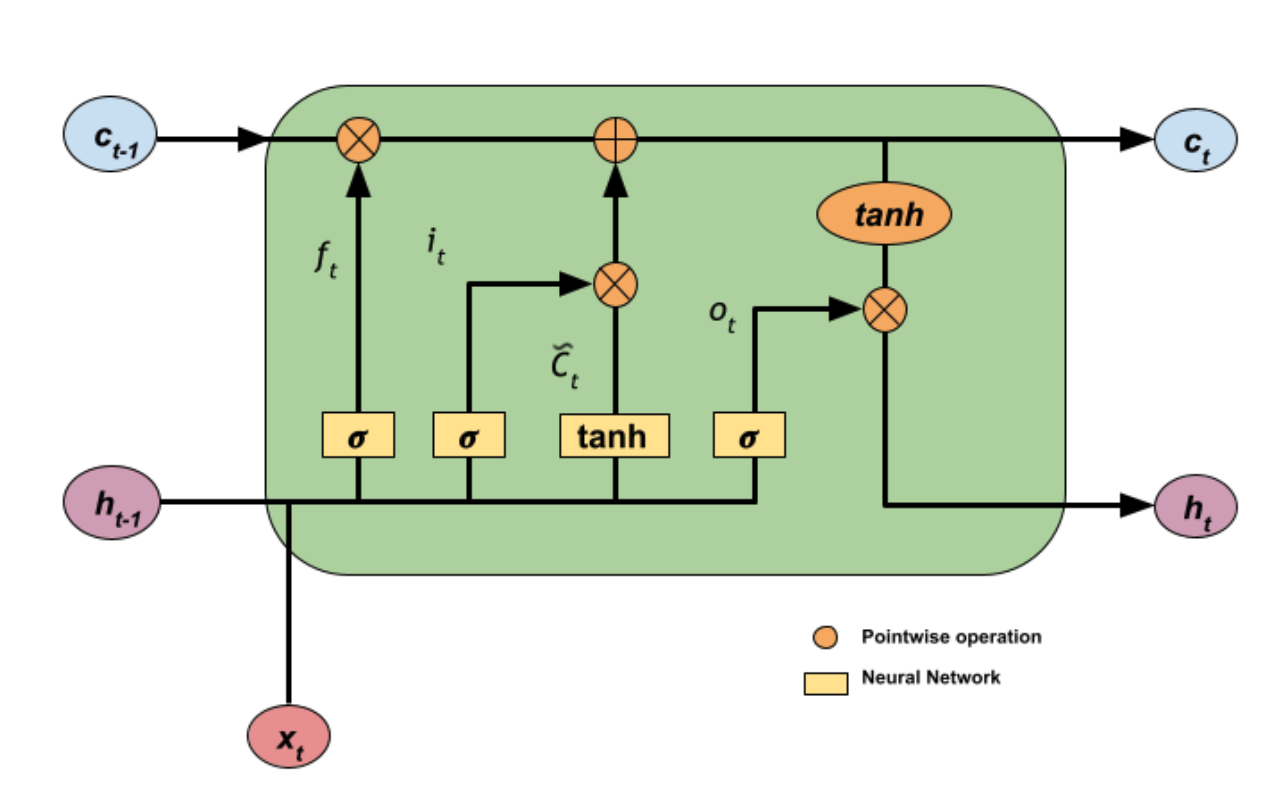

Figure shows the internal working of the LSTM. $h_t$ stands for hidden state, $c_t$ is the cell state for time step $t$, and $x_t$ is the input at time step $t$. Similarly, $f_t$ is the forget gate, $i_t$ for the input gate, and $o_t$ is the output gate.

In [ ]:
def lstm_data_prep(data_frame, feature_names, label_names, time_lag=10, pred_period=0, scaling_func=None, pct_train=0.80):
    """
    Prepare data for input into an LSTM model.

    Args:
        data_frame (DataFrame): A pandas DataFrame containing features and labels.
        feature_names (list): List of column names that will be used as input features.
        label_names (list): List of column names that will be used as output labels.

    Kwargs:
        time_lag (int): Time to lag datasets. Default is 10 periods.
        pred_period (int): Time period as forecast outputs. Default is 0 (next day forecast).
        scaling_func (sklearn.preprocessing function): Function to preprocess features.
        pct_train (float): Percent of data to be used for training. Used to prevent scaling on all features.

    Returns:
        X_train (numpy array): Array of training features.
        X_test (numpy array): Array of testing features.
        y_train (numpy array): Array of training labels.
        y_test (numpy array): Array of testing labels.
    """
    # Get features
    X = data_frame[feature_names].values

    # Get the labels
    if pred_period > 0:
        y = data_frame[label_names][time_lag: -pred_period].values
    else:
        y = data_frame[label_names][time_lag:].values

    n_train = int(pct_train * X.shape[0])

    # If a scaling function is provided, scale the data
    if scaling_func is not None:
        scaler = scaling_func.fit(X[:n_train])
        X_scaled = scaler.transform(X)
    else:
        X_scaled = X

    x_shape = [y.shape[0], time_lag, X.shape[1]]
    y_shape = [y.shape[0], pred_period] if pred_period > 0 else [y.shape[0], 1]
    out_X = np.zeros(x_shape)
    out_y = np.zeros(y_shape)

    for i in range(y.shape[0] - pred_period):
        # index tracker for X
        v = time_lag + i if i > 0 else time_lag
        # index tracker for y
        u = pred_period + i if pred_period > 0 else i + 1

        out_X[i, :, :] = X_scaled[i:v, :]
        out_y[i, :] = y[i : u][0] # from (shape, 1) to (shape,)

    n_train = int(pct_train * out_X.shape[0])

    X_train, X_test = out_X[:n_train, :, :], out_X[n_train:, :, :]
    y_train, y_test = out_y[:n_train, :], out_y[n_train:, :]

    return X_train, X_test, y_train, y_test


Now that we have the data preparation function ready, let's proceed to utilize it.

In the `lstm_data_prep` function, we define several parameters that will be passed to the data preparation process. We choose to use 365 days as input into the model, utilize all the available meteorological data, and allocate 85% of the data for training purposes.

In [ ]:
time_days = 365
feature_columns = ["precip", "tmin", "tmax", "uwind", "vwind", "psurface"]
label_columns = ["discharge"]
pct_train = 0.85

scaler = preprocessing.RobustScaler()
# scaler = preprocessing.MinMaxScaler()

X_train, X_test, y_train, y_test = lstm_data_prep(model_df, feature_columns, label_columns, time_lag=time_days, scaling_func=scaler, pct_train=pct_train)

Lets check to make sure the data is properly formatted. Remember the format of LSTM is **[batch, time, features]**.

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(9004, 365, 6) (9004, 1) (1590, 365, 6) (1590, 1)


The `X_train` array has 3 dimensions, including `batch_size, time, features` information. On the other hand, the `y_train` array matches the length of the samples. This ensures that the data is properly formatted and aligns with the requirements of our LSTM model.

Next, we will define a function to build our LSTM model. The model will consist of a LSTM layer with skip connection with a LSTM features. We will also do a `dropout=0.2` to avoid overfitting. The function will compile the model and return it, ready for use in our hydrologic modeling tasks.

*Note*: You could also use `recurrent_dropout` but this could be really slow in training.

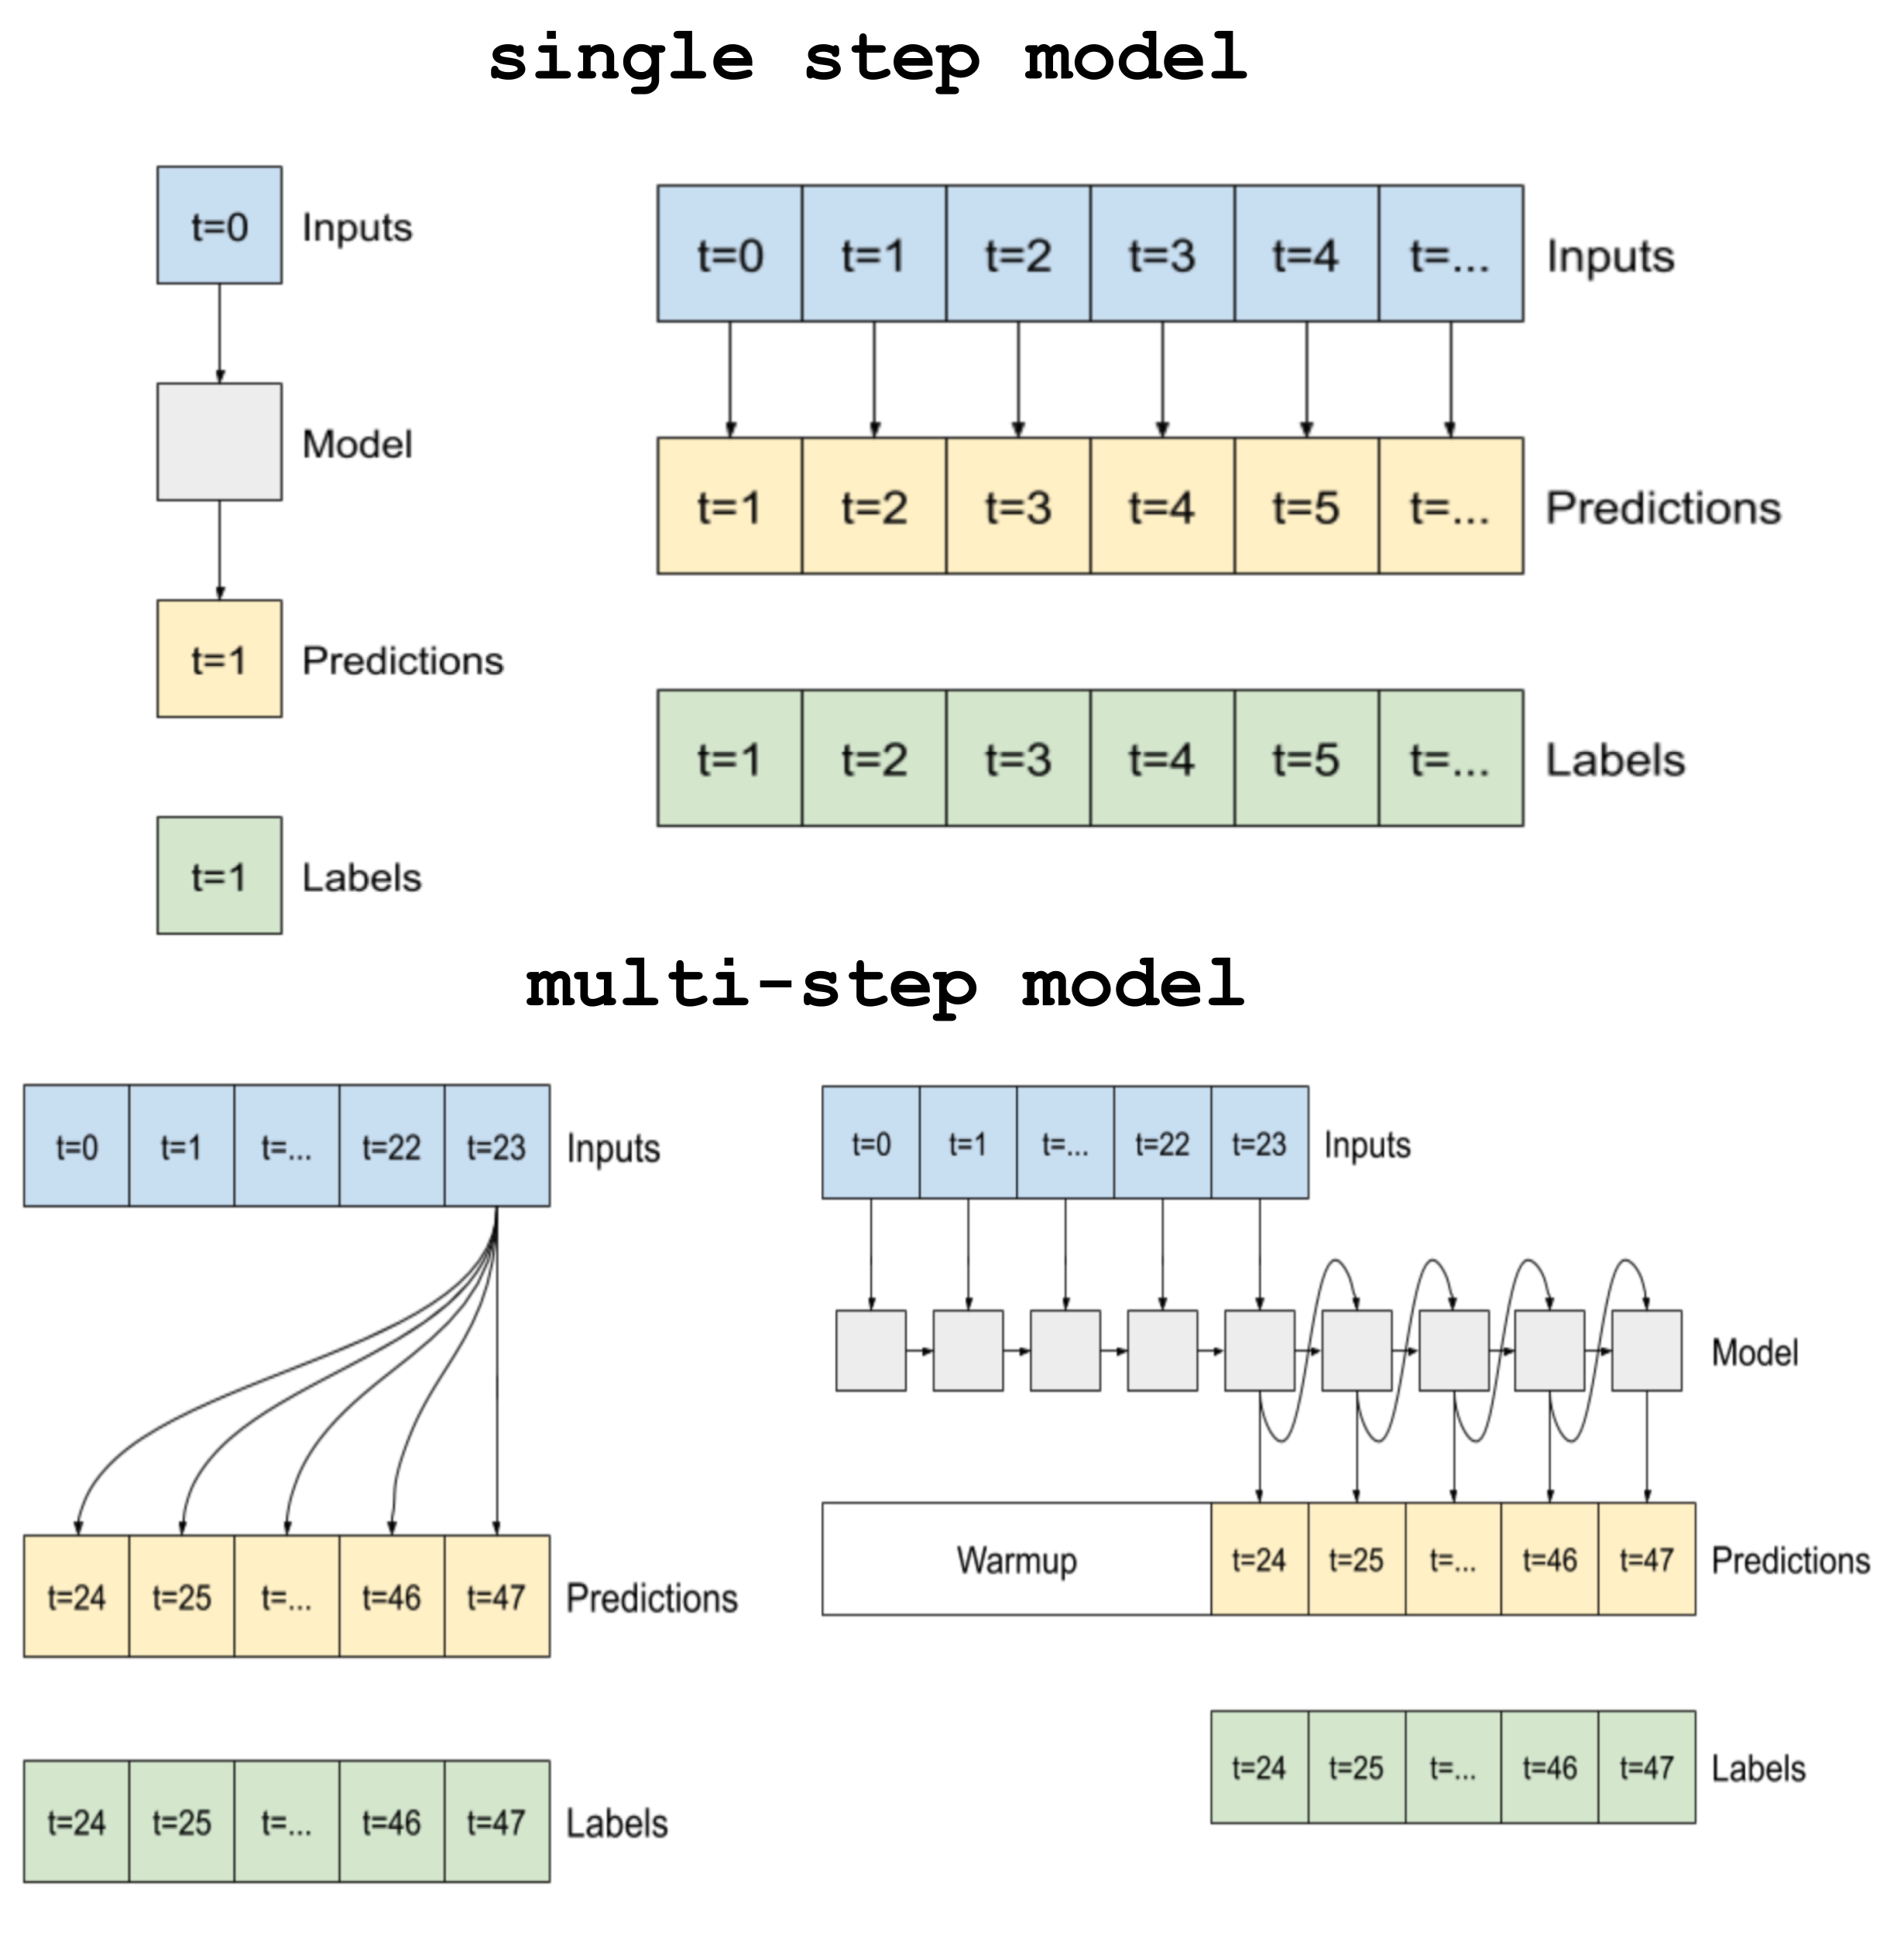

Source:[Tensorflow Tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series)
(License: CC-BY)

In [ ]:
def build_model(input_shape, output_shape, nodes=64, optimizer="adam", loss="mse"):
    """
    Build an LSTM model.

    Args:
        input_shape (list or tuple): Input shape for the model, representing [time, features].
        output_shape (int): Output shape for the model, representing [output_shape].

    Kwargs:
        nodes (int): Number of nodes to use in LSTM layers. Default is 64.
        optimizer (str or optimizer): Optimizer to use for the model. Default is Adam optimizer.
        loss (str): Loss function to use for the model. Default is mean squared error (MSE).

    Returns:
        model (keras.Model): Compiled Keras model ready for training.
    """
    inputs = layers.Input(input_shape, name="input_layer")

    x = layers.LSTM(input_shape[1], return_sequences=True, name="lstm_layer")(inputs)

    skip_output = layers.Add()([inputs, x])

    X = layers.LSTM(nodes, return_sequences=False, dropout=0.2)(skip_output)  # recurrent_dropout=0.2

    outputs = layers.Dense(output_shape, activation="linear", name="output_layer")(X)

    model = models.Model(inputs=[inputs], outputs=[outputs], name="lstm_hm")

    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=["mape", "mae", "mse"])

    return model


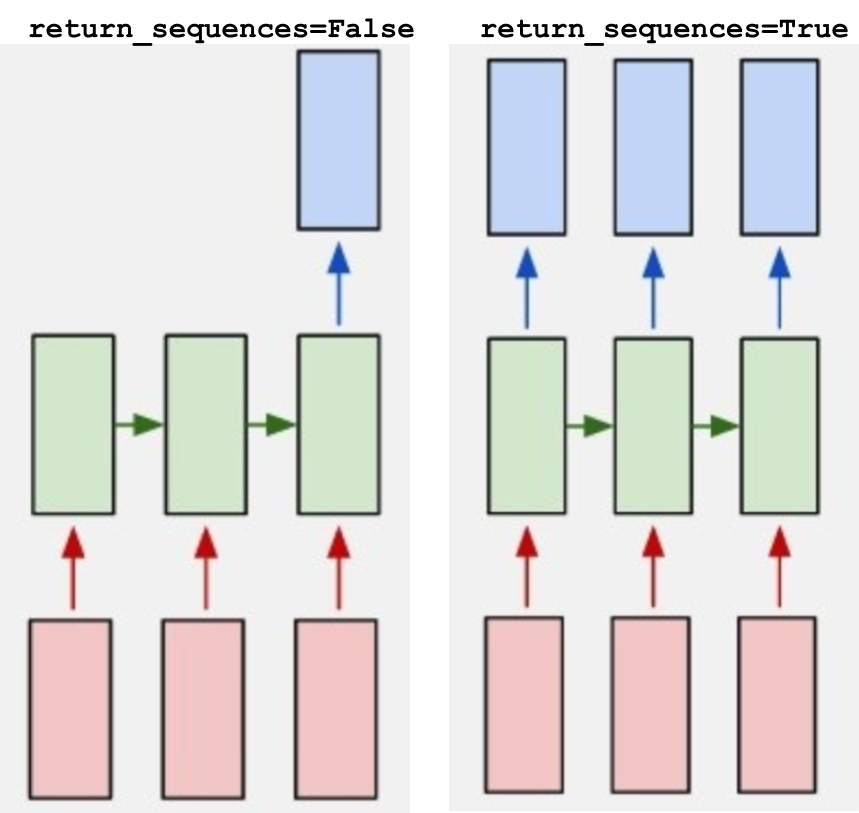

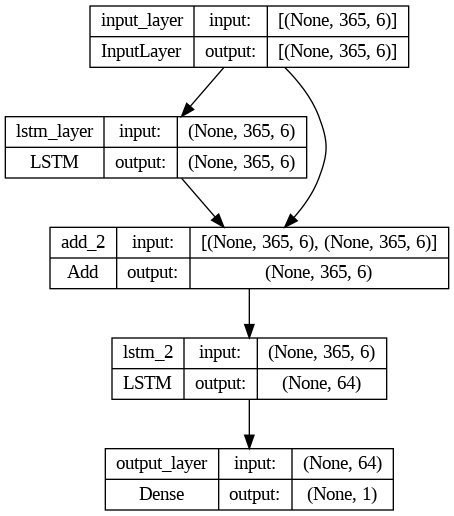

In hydrologic modeling, the Nash-Sutcliffe Efficiency (NSE) is commonly used as a model metric. Here, we define a custom loss function to calculate NSE. Since NSE values range from negative infinity (-$\infty$) to 1 (where 1 represents a perfect model), we'll invert the values so that -1 represents the best model.

*Note*: Feel free to experiment with different loss function. We will try `nse_loss` and `huber_loss`.

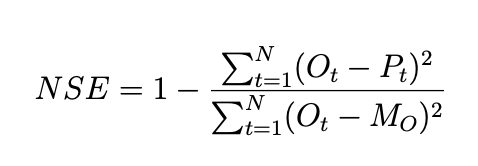

where $N$ is the length of the dataset, $O_t$ is the observed discharge at time $t$ , $P_t$ is the predicted discharge at that time, and $M_O$ is the mean of the observed discharges

In [ ]:
def nse_loss(y_true, y_pred):
    """
    Calculate the Nash-Sutcliffe model efficiency coefficient (NSE).

    From: https://en.wikipedia.org/wiki/Nash%E2%80%93Sutcliffe_model_efficiency_coefficient
    NSE is commonly used in hydrology to evaluate model performance (NSE > 0.7 is considered good).

    Args:
        y_true (tf.Tensor): Tensor with true values from observations/labels.
        y_pred (tf.Tensor): Tensor of predicted values from the model.

    Returns:
       tf.Tensor: Inverted NSE value (lower values are better).
    """
    numerator = K.sum(K.pow(y_true - y_pred, 2))
    denominator = K.sum(K.pow(y_true - K.mean(y_true), 2)) + K.epsilon()
    nse = 1 - (numerator / denominator)
    return -1 * nse


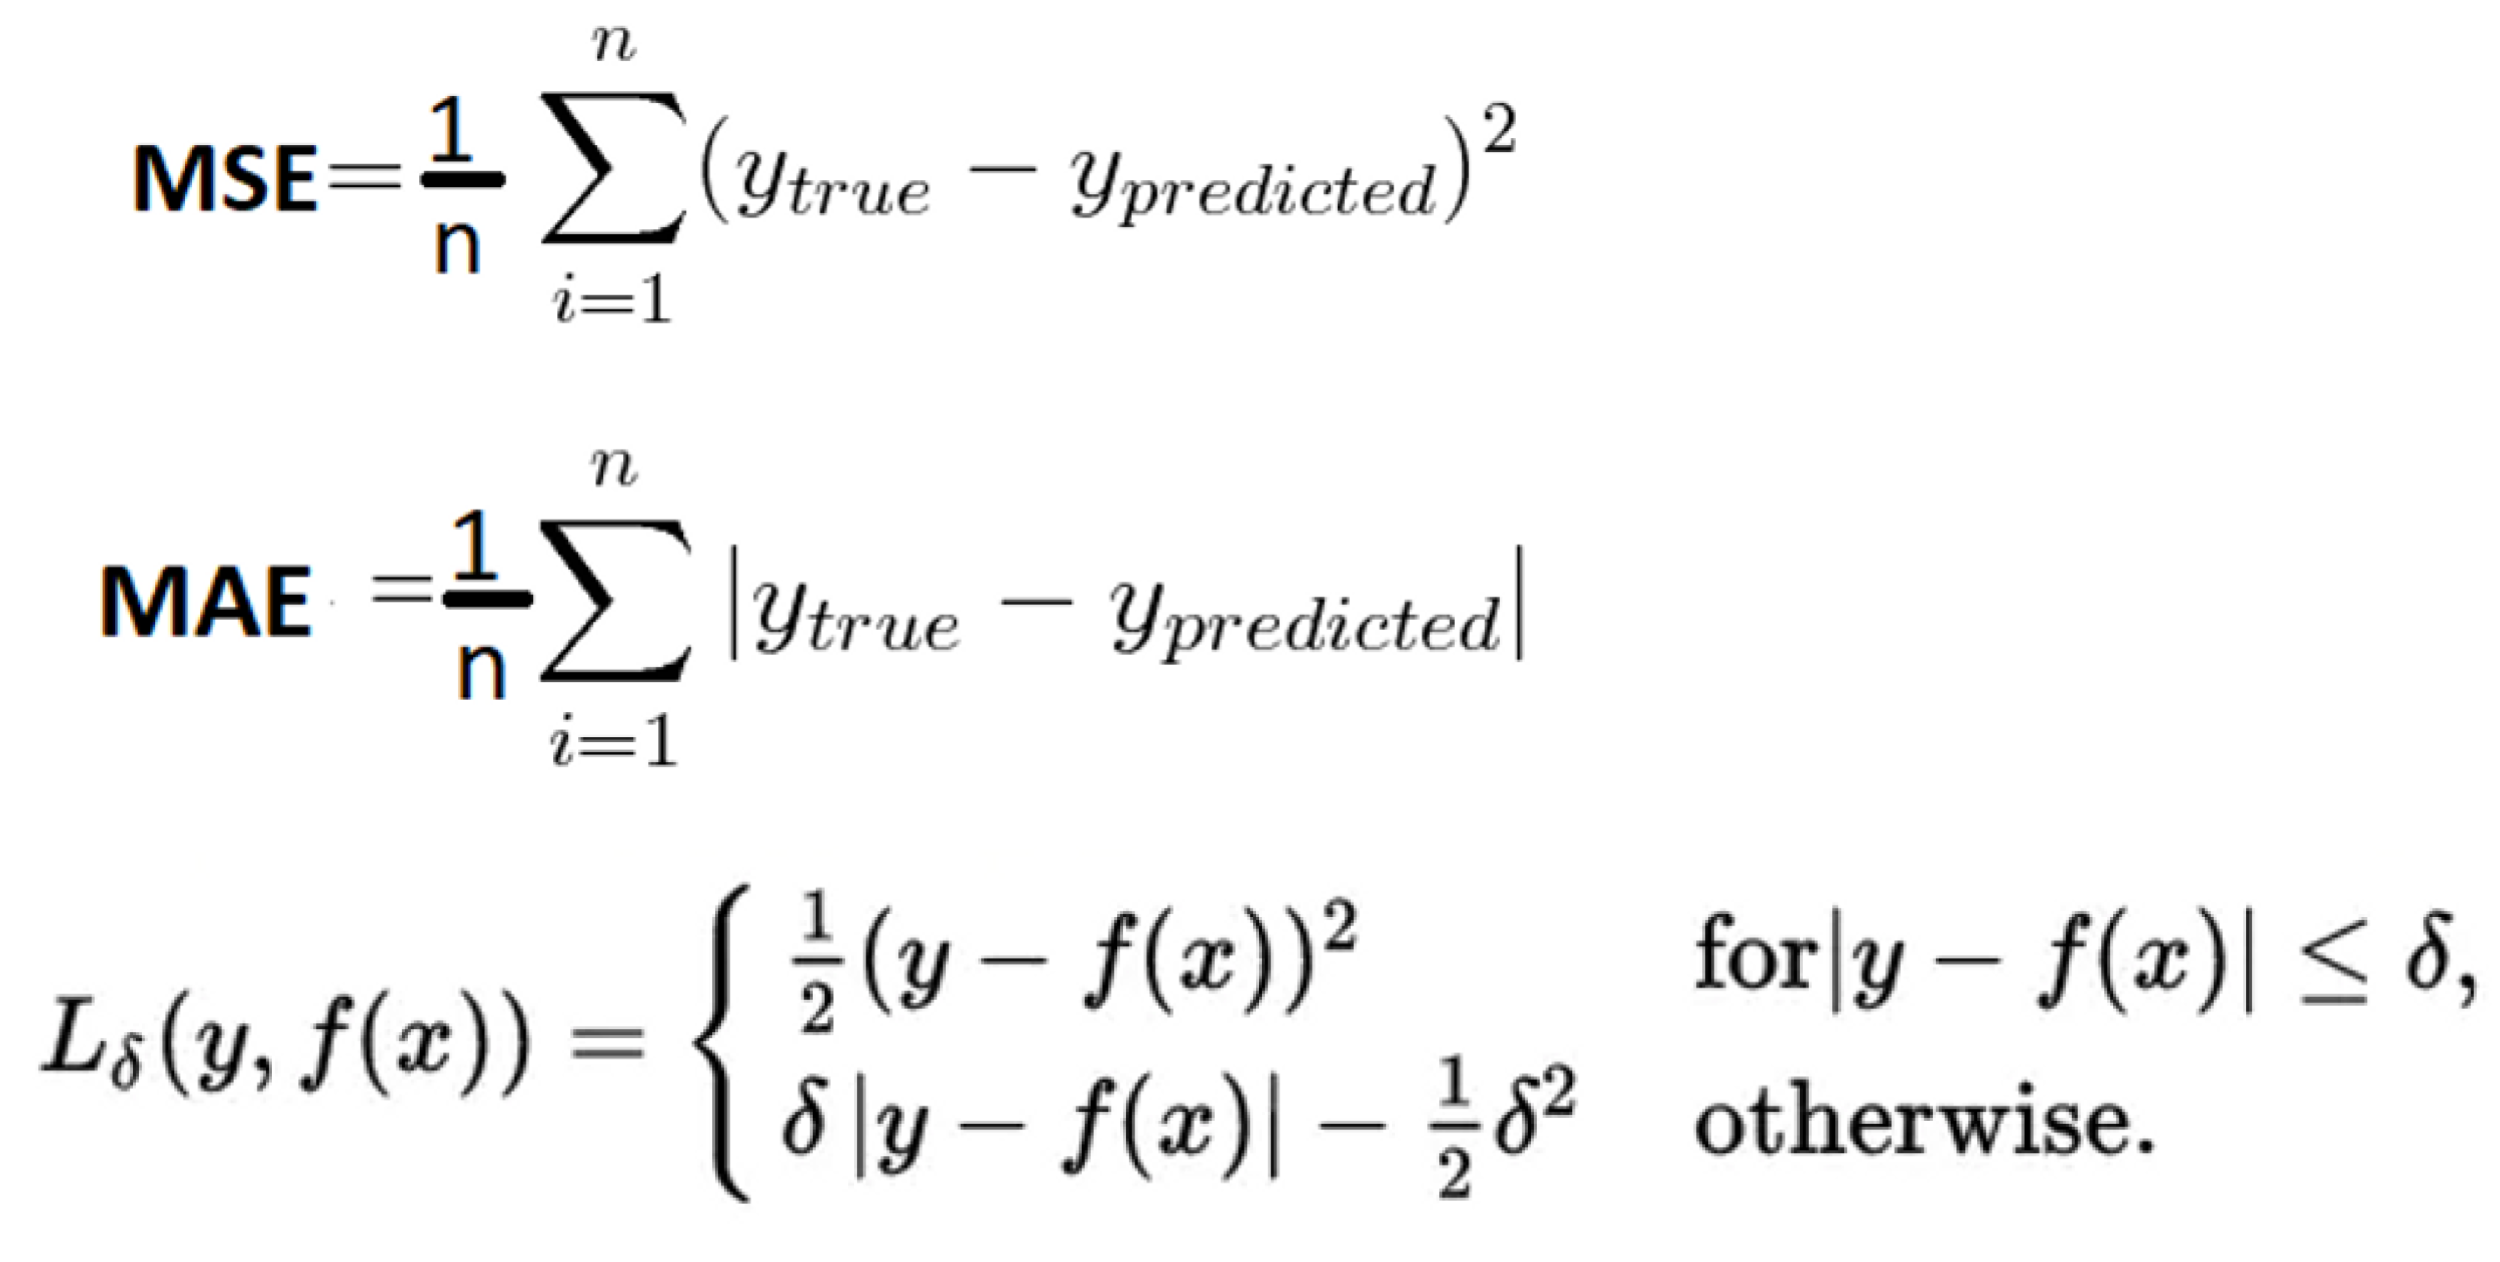

Now we can build our LSTM model. We specify the input and output shape parameters and experiment with different loss functions, including the custom `nse_loss` function. This allows us to evaluate the model's performance using various metrics, including the Nash-Sutcliffe model efficiency coefficient (NSE).

In [ ]:
inshape = time_days, len(feature_columns)
outshape = 1

EPOCHS = 50
STEPS_PER_EPOCH = 280
BATCH_SIZE = X_train.shape[0]//STEPS_PER_EPOCH
print(f"BATCH_SIZE: {BATCH_SIZE}")
VAL_SPLIT = 0.1

# clipping value to avoid gradient going inf
optimizer = optimizers.Adam(learning_rate=0.001, clipvalue=1.0)


BATCH_SIZE: 32


In [ ]:
model_nse = build_model(inshape, outshape, optimizer=optimizer, loss=nse_loss)
keras.utils.plot_model(model_nse, "model_nse.png", show_shapes=True)
model_nse.summary()

Model: "lstm_hm"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 365, 6)]     0           []                               
                                                                                                  
 lstm_layer (LSTM)              (None, 365, 6)       312         ['input_layer[0][0]']            
                                                                                                  
 add (Add)                      (None, 365, 6)       0           ['input_layer[0][0]',            
                                                                  'lstm_layer[0][0]']             
                                                                                                  
 lstm (LSTM)                    (None, 64)           18176       ['add[0][0]']              

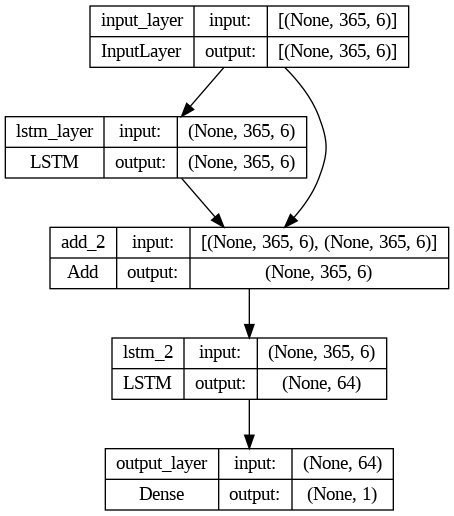

In [ ]:
training_nse = model_nse.fit(x=X_train,
                             y=y_train,
                             epochs=EPOCHS,
                             batch_size=BATCH_SIZE,
                             validation_split=VAL_SPLIT)

Epoch 1/50
254/254 [==============================] - 14s 24ms/step - loss: 0.7020 - mape: 66.9465 - mae: 59.9819 - mse: 9822.1543 - val_loss: 1.7644 - val_mape: 53.2841 - val_mae: 60.7533 - val_mse: 11946.3848
Epoch 2/50
254/254 [==============================] - 5s 21ms/step - loss: 0.3697 - mape: 63.3586 - mae: 50.8107 - mse: 8207.4531 - val_loss: 1.5448 - val_mape: 50.5360 - val_mae: 53.7825 - val_mse: 10599.1973
Epoch 3/50
254/254 [==============================] - 5s 20ms/step - loss: 0.2009 - mape: 77.0214 - mae: 47.9714 - mse: 7347.6509 - val_loss: 2.6699 - val_mape: 55.8273 - val_mae: 50.8619 - val_mse: 9746.3623
Epoch 4/50
254/254 [==============================] - 5s 20ms/step - loss: 0.0594 - mape: 65.2952 - mae: 43.5218 - mse: 6670.6406 - val_loss: 2.6936 - val_mape: 46.0455 - val_mae: 46.2151 - val_mse: 8980.2295
Epoch 5/50
254/254 [==============================] - 5s 21ms/step - loss: -0.0701 - mape: 49.0071 - mae: 38.8991 - mse: 6038.1958 - val_loss: 1.6129 - val_mape:

With our model trained, let's analyze the training process. We will plot the history and examine the loss and some metric values for each epoch. This will give us valuable insights into how the model performed during the training phase.

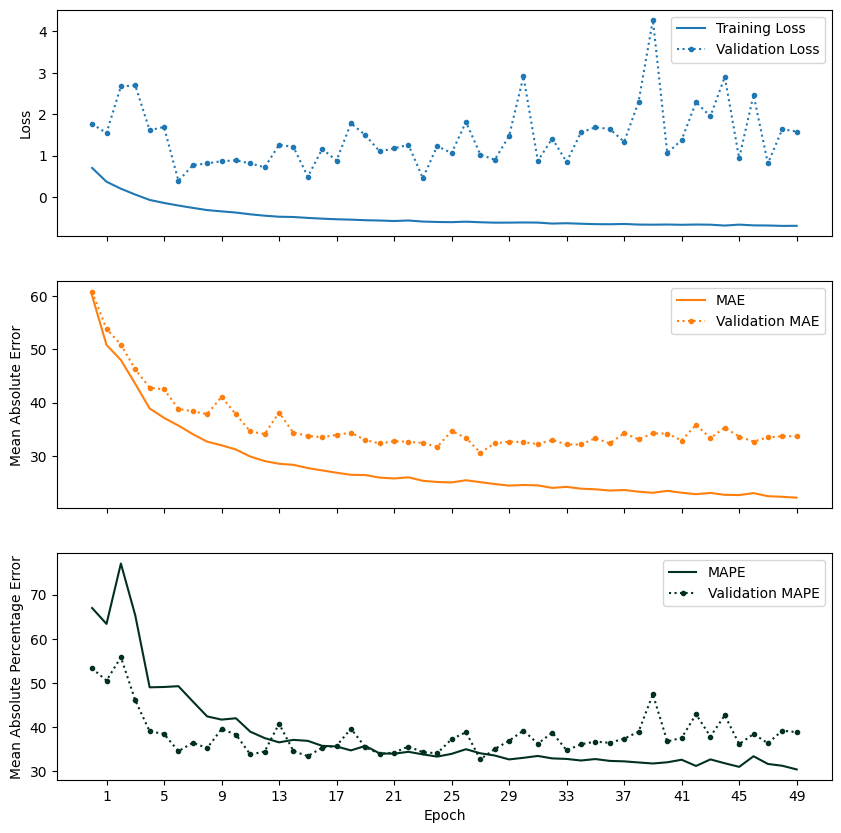

In [ ]:
fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(10, 10))

ax[0].plot(training_nse.history["loss"], color="#1f77b4", label="Training Loss")
ax[0].plot(training_nse.history["val_loss"], linestyle=":", marker="o", markersize=3, color="#1f77b4", label="Validation Loss")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(training_nse.history["mae"], color="#ff7f0e", label="MAE")
ax[1].plot(training_nse.history["val_mae"], linestyle=":", marker="o", markersize=3, color="#ff7f0e", label="Validation MAE")
ax[1].legend()
ax[1].set_ylabel("Mean Absolute Error")


ax[2].plot(training_nse.history["mape"], color="#023020", label="MAPE")
ax[2].plot(training_nse.history["val_mape"], linestyle=":", marker="o", markersize=3, color="#023020", label="Validation MAPE")
ax[2].legend()
ax[2].set_xlabel("Epoch")
ax[2].set_ylabel("Mean Absolute Percentage Error")

ax[2].set_xticks(range(1, len(training_nse.epoch)+1, 4))
ax[2].set_xticklabels(range(1, len(training_nse.epoch)+1, 4))

plt.legend()
plt.show()

Next let's try to train a model using `huber_loss` and see how it compares to the custom `nse_loss`.

In [ ]:
model_huber = build_model(inshape, outshape, optimizer=optimizer, loss="huber_loss")
keras.utils.plot_model(model_huber, "model_huber.png", show_shapes=True)
training_huber = model_huber.fit(x=X_train,
                                 y=y_train,
                                 epochs=EPOCHS,
                                 batch_size=BATCH_SIZE,
                                 validation_split=VAL_SPLIT)

Epoch 1/50
254/254 [==============================] - 10s 28ms/step - loss: 50.1947 - mape: 71.4141 - mae: 50.6903 - mse: 7993.0312 - val_loss: 51.0552 - val_mape: 55.0767 - val_mae: 51.5524 - val_mse: 9931.9238
Epoch 2/50
254/254 [==============================] - 5s 22ms/step - loss: 47.0165 - mape: 85.1641 - mae: 47.5131 - mse: 7051.9150 - val_loss: 50.4013 - val_mape: 57.2247 - val_mae: 50.8965 - val_mse: 9696.9590
Epoch 3/50
254/254 [==============================] - 5s 21ms/step - loss: 44.4535 - mape: 70.4522 - mae: 44.9490 - mse: 6848.4761 - val_loss: 44.5830 - val_mape: 41.9404 - val_mae: 45.0768 - val_mse: 8950.5742
Epoch 4/50
254/254 [==============================] - 5s 21ms/step - loss: 37.6148 - mape: 42.2910 - mae: 38.1051 - mse: 6033.2661 - val_loss: 40.2220 - val_mape: 35.2321 - val_mae: 40.7170 - val_mse: 8145.2852
Epoch 5/50
254/254 [==============================] - 6s 23ms/step - loss: 34.6037 - mape: 38.6733 - mae: 35.0933 - mse: 5433.4048 - val_loss: 39.4836 - va

With our model trained, now let's plot the history and examine the loss and some metric values for each epoch with the huber loss model.

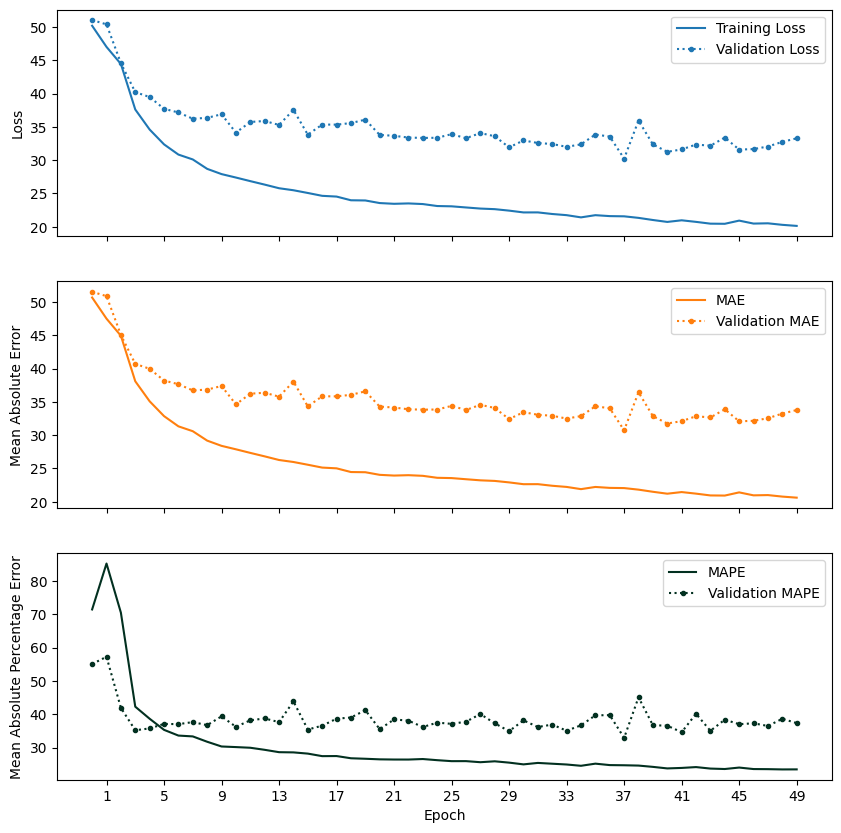

In [ ]:
fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(10, 10))

ax[0].plot(training_huber.history["loss"], color="#1f77b4", label="Training Loss")
ax[0].plot(training_huber.history["val_loss"], linestyle=":", marker="o", markersize=3, color="#1f77b4", label="Validation Loss")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(training_huber.history["mae"], color="#ff7f0e", label="MAE")
ax[1].plot(training_huber.history["val_mae"], linestyle=":", marker="o", markersize=3, color="#ff7f0e", label="Validation MAE")
ax[1].legend()
ax[1].set_ylabel("Mean Absolute Error")


ax[2].plot(training_huber.history["mape"], color="#023020", label="MAPE")
ax[2].plot(training_huber.history["val_mape"], linestyle=":", marker="o", markersize=3, color="#023020", label="Validation MAPE")
ax[2].legend()
ax[2].set_xlabel("Epoch")
ax[2].set_ylabel("Mean Absolute Percentage Error")

ax[2].set_xticks(range(1, len(training_huber.epoch)+1, 4))
ax[2].set_xticklabels(range(1, len(training_huber.epoch)+1, 4))

plt.legend()
plt.show()

Apart from inspecting the training history, we can predict the streamflow from the test samples and evaluate the model's performance. This step allows us to assess how well the model performs on unseen data and provides further validation for its effectiveness.

In [ ]:
# apply the prediction
y_pred_nse = model_nse.predict(X_test)
y_pred_huber = model_huber.predict(X_test)

# drop the extra dimension for the prediction and test arrays
# this is done for plotting
y_pred_nse = np.squeeze(y_pred_nse)
y_pred_huber = np.squeeze(y_pred_huber)
y_test = np.squeeze(y_test)

50/50 [==============================] - 1s 9ms/step


In [ ]:
# calculate RMSE and nse to see how well are predictions are doing
rmse_nse = np.mean(np.sqrt(np.power((y_test - y_pred_nse), 2)))
rmse_huber = np.mean(np.sqrt(np.power((y_test - y_pred_huber), 2)))
nse_nse = 1 - (np.sum(np.power((y_test - y_pred_nse), 2)) / np.sum(np.power((y_test - y_test.mean()), 2)))
nse_huber = 1 - (np.sum(np.power((y_test - y_pred_huber), 2)) / np.sum(np.power((y_test - y_test.mean()), 2)))

We can now plot our results to inspect how our model performs on data it has not encountered before. This visualization will help us assess the model's performance and gain insights into its effectiveness in predicting streamflow on unseen data.

 >> (nse_loss) NSE: 0.5933  RMSE: 34.9111
 >> (huber_loss) NSE: 0.5540  RMSE: 37.0688


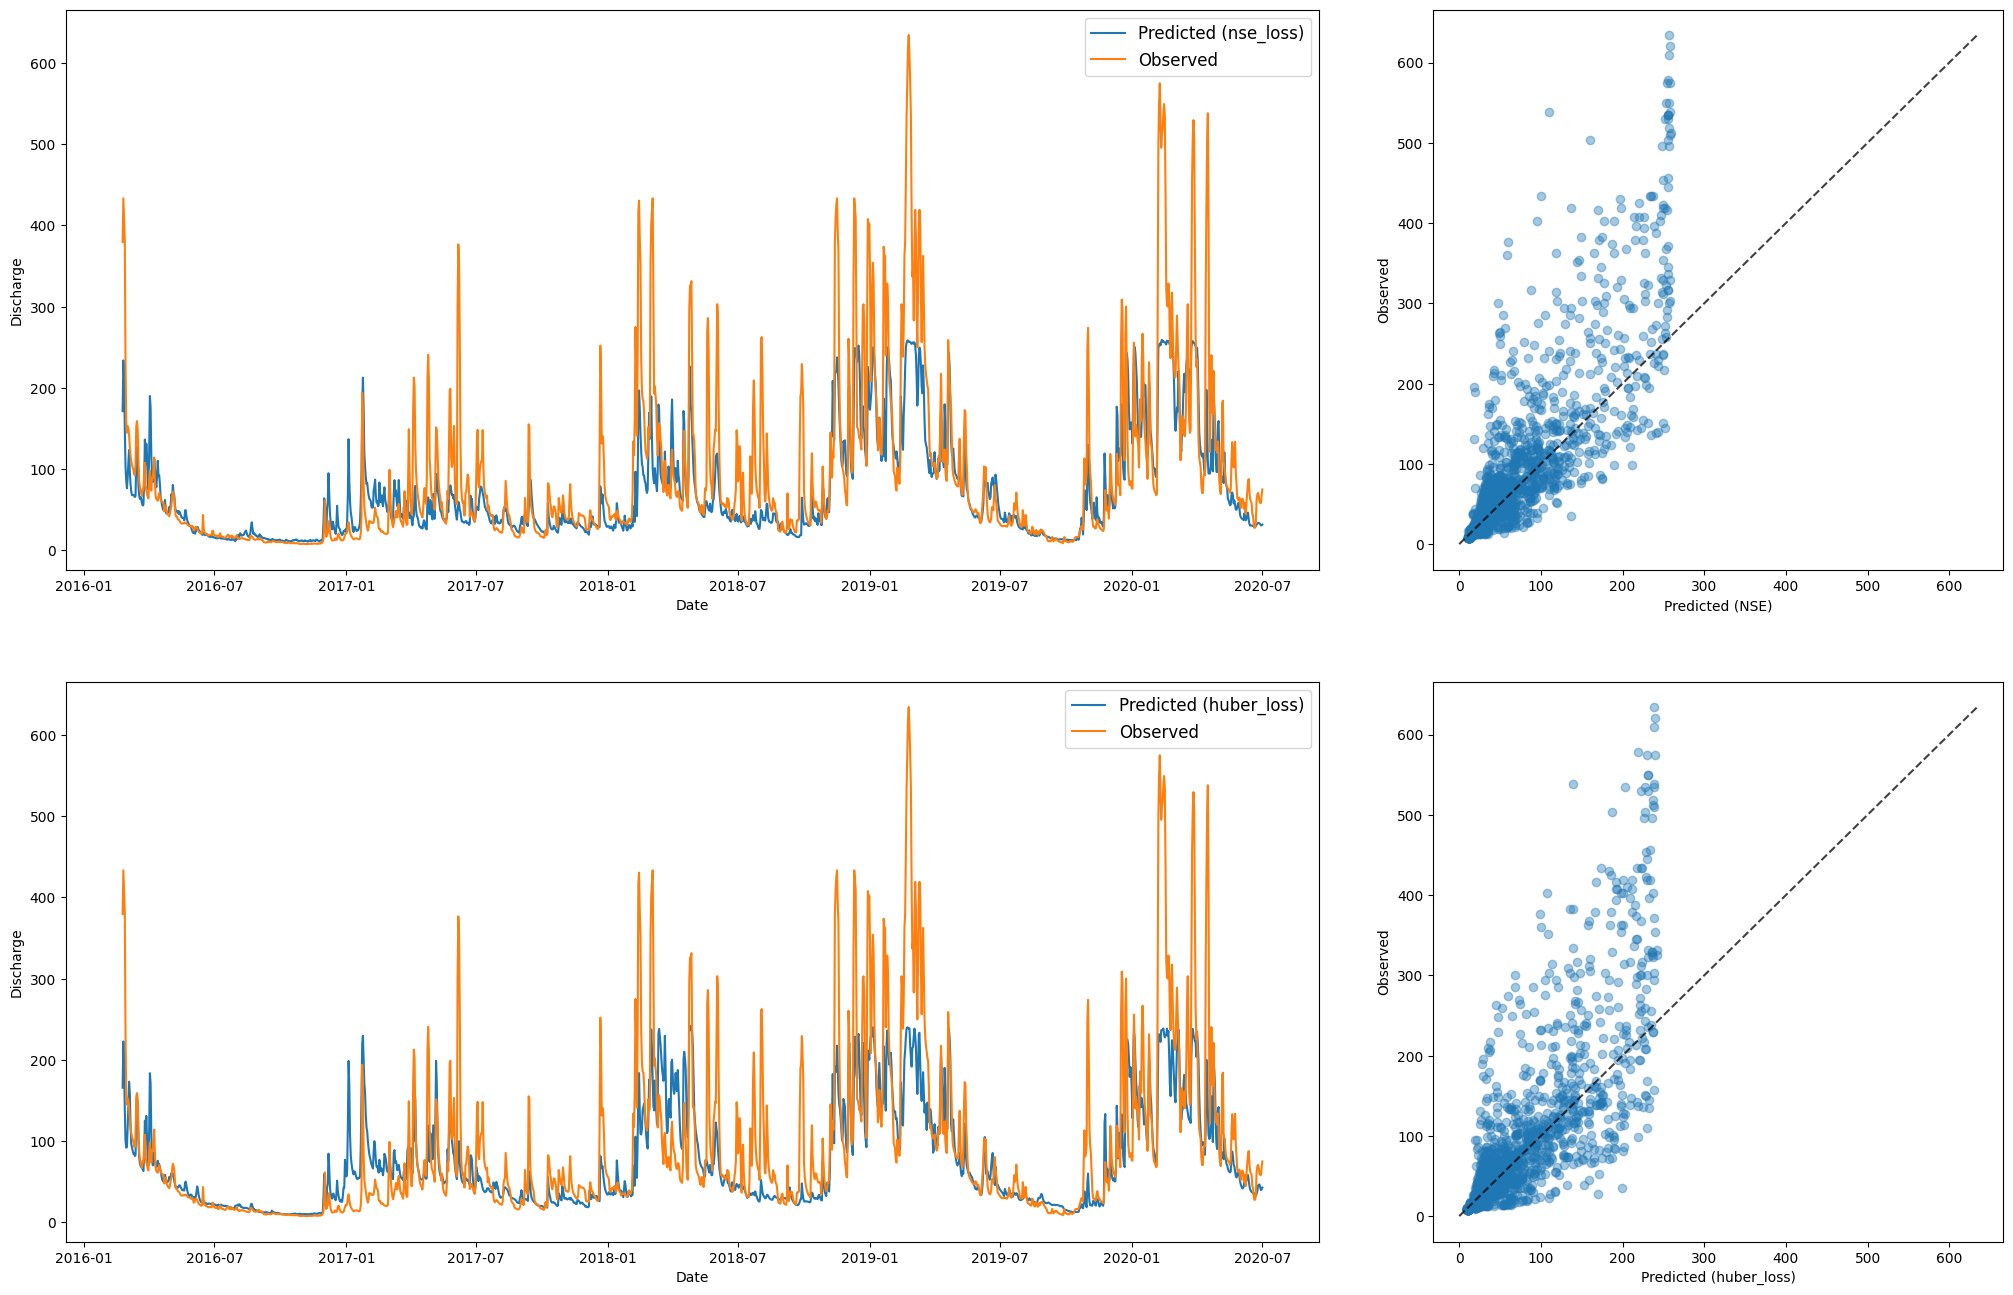

In [ ]:
print(f" >> (nse_loss) NSE: {nse_nse:.4f}  RMSE: {rmse_nse:.4f}")
print(f" >> (huber_loss) NSE: {nse_huber:.4f}  RMSE: {rmse_huber:.4f}")

eval_dates = model_df.iloc[X_train.shape[0] + time_days :].index

fig = plt.figure(figsize=(25, 16))
gs = fig.add_gridspec(2, 3)

ax1 = fig.add_subplot(gs[0, :2])
ax1.plot(eval_dates, y_pred_nse, label="Predicted (nse_loss)")
ax1.plot(eval_dates, y_test, label="Observed")
ax1.set_xlabel("Date")
ax1.set_ylabel("Discharge")
ax1.legend(fontsize=12)

ax2 = fig.add_subplot(gs[0, 2:])
ax2.plot(y_pred_nse, y_test, "o", alpha=0.4)
ax2.plot([0,y_test.max()], [0,y_test.max()], "k--", alpha=0.75)
ax2.set_xlabel("Predicted (NSE)")
ax2.set_ylabel("Observed")


ax3 = fig.add_subplot(gs[1, :2])
ax3.plot(eval_dates, y_pred_huber, label="Predicted (huber_loss)")
ax3.plot(eval_dates, y_test, label="Observed")
ax3.set_xlabel("Date")
ax3.set_ylabel("Discharge")
ax3.legend(fontsize=12)

ax4 = fig.add_subplot(gs[1, 2:])
ax4.plot(y_pred_huber, y_test, "o", alpha=0.4)
ax4.plot([0,y_test.max()], [0,y_test.max()], "k--", alpha=0.75)
ax4.set_xlabel("Predicted (huber_loss)")
ax4.set_ylabel("Observed")

plt.show()

Great work! The hindcast results are promising, and there are numerous ways to customize the model to further enhance its accuracy. This example serves as a helpful starting point, and you have the flexibility to tailor the model to suit your specific application and requirements. The possibilities for customization are vast, and you can explore various techniques to optimize and improve the model's performance for your hydrologic modeling tasks. Keep experimenting and enjoy the journey!

## Bonus - Forecasting streamflow

In the previous example, we learned how to use LSTM for generating observed streamflow data. But what if we want to forecast future streamflow? The good news is that we can do that too with a simple adjustment to the input data. By making some modifications to the data inputs, we can effectively use LSTM for streamflow forecasting. Let's explore this exciting capability and harness LSTM's power for making streamflow predictions into the future.

To perform a forecast, we need to set a `forecast_lead` variable, which indicates the number of days to forecast. Additionally, we adjust our `time_lag` to 120 days. Then, we obtain our training and testing data using the updated dimensions to prepare for forecasting.

In [ ]:
feature_columns = ["precip", "tmin", "tmax", "uwind", "vwind", "psurface"]
label_columns = ["discharge"]
pct_train = 0.85

time_lag = 120
pred_period = 5

# scaler = preprocessing.MinMaxScaler()
scaler = preprocessing.RobustScaler()


X_train, X_test, y_train, y_test = lstm_data_prep(model_df, feature_columns, label_columns, time_lag=time_lag, pred_period=pred_period, scaling_func=scaler, pct_train=pct_train)


Lets check to make sure the data is properly formatted. Remember the format of LSTM is **[batch, time, features]**.


In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(9208, 120, 6) (9208, 5) (1626, 120, 6) (1626, 5)


We can now build the forecast model using the same model architecture as before. The dimensions of the input data will be adjusted accordingly to accommodate the forecast lead and time lag.

In [ ]:
inshape = time_lag, len(feature_columns)
outshape = pred_period

EPOCHS = 50
STEPS_PER_EPOCH = 500
BATCH_SIZE = X_train.shape[0]//STEPS_PER_EPOCH
print(f"BATCH_SIZE: {BATCH_SIZE}")
VAL_SPLIT = 0.1

# clipping value to avoid gradient going inf
optimizer = optimizers.Adam(learning_rate=0.001, clipvalue=1.0)

forecast_model = build_model(inshape, outshape, optimizer=optimizer, loss="huber_loss")
keras.utils.plot_model(forecast_model, "forecast_model.png", show_shapes=True)
forecast_model.summary()

BATCH_SIZE: 18
Model: "lstm_hm"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 120, 6)]     0           []                               
                                                                                                  
 lstm_layer (LSTM)              (None, 120, 6)       312         ['input_layer[0][0]']            
                                                                                                  
 add_2 (Add)                    (None, 120, 6)       0           ['input_layer[0][0]',            
                                                                  'lstm_layer[0][0]']             
                                                                                                  
 lstm_2 (LSTM)                  (None, 64)           18176       ['add_2[0][0

Now we fit the model.

In [ ]:
forecast_training = forecast_model.fit(x=X_train,
                                       y=y_train,
                                       epochs=EPOCHS,
                                       batch_size=BATCH_SIZE,
                                       validation_split=VAL_SPLIT)

Epoch 1/50
461/461 [==============================] - 8s 12ms/step - loss: 57.8754 - mape: 65.4696 - mae: 58.3703 - mse: 9621.2217 - val_loss: 54.8086 - val_mape: 49.2482 - val_mae: 55.3041 - val_mse: 11200.7949
Epoch 2/50
461/461 [==============================] - 5s 11ms/step - loss: 48.8950 - mape: 70.6019 - mae: 49.3918 - mse: 7815.1011 - val_loss: 49.8239 - val_mape: 52.0191 - val_mae: 50.3216 - val_mse: 10053.9795
Epoch 3/50
461/461 [==============================] - 5s 10ms/step - loss: 43.5880 - mape: 55.0924 - mae: 44.0816 - mse: 7053.7954 - val_loss: 44.0615 - val_mape: 36.4961 - val_mae: 44.5536 - val_mse: 9210.0518
Epoch 4/50
461/461 [==============================] - 5s 10ms/step - loss: 37.1018 - mape: 39.7880 - mae: 37.5922 - mse: 6018.3911 - val_loss: 41.7554 - val_mape: 35.1537 - val_mae: 42.2482 - val_mse: 8595.0762
Epoch 5/50
461/461 [==============================] - 5s 11ms/step - loss: 33.9352 - mape: 37.3108 - mae: 34.4240 - mse: 5325.4717 - val_loss: 37.8770 - v

In [ ]:
# run the predictions
forecast = forecast_model.predict(X_test)
 # print the shape (sanity check)
forecast.shape

51/51 [==============================] - 1s 4ms/step


(1626, 5)

We have the model and the prediction outputs ready. Now, let's examine the results, although visualizing time series forecasts can be tricky.

To simplify this task, we'll utilize IPython widgets. Here, we define a function to plot our forecasts. Using a date picker, we can visualize the forecast for a specific day. The function plots the historical streamflow along with the predicted and true streamflow based on the selected forecast date. This interactive visualization aids in understanding the forecast performance more effectively.

But first let's see the ranges of our evaluation dates

In [ ]:
eval_dates = model_df.iloc[X_train.shape[0] + time_lag:].index
print(f"start_date: {eval_dates[:1][0]}, end_date: {eval_dates[-1:][0]}")

start_date: 2016-01-14 00:00:00, end_date: 2020-07-01 00:00:00


In [ ]:
from ipywidgets import *
import datetime

eval_dates = model_df.iloc[X_train.shape[0] + time_lag:].index
init_date = datetime.datetime(2018, 5, 1)

@widgets.interact(date=DatePicker(description="Pick a Date:", value=init_date))
def plotUpdate(date):
    index_eval = int(np.where(eval_dates == str(date))[0])
    fig, ax = plt.subplots(figsize=(15, 8))
    historic = ax.plot(eval_dates[index_eval - pred_period*3: index_eval], y_test[index_eval - pred_period*3: index_eval, 0], label="historic", alpha=0.5)
    predicted = ax.plot(eval_dates[index_eval: index_eval + pred_period], forecast[index_eval, :], color="C1", marker="o", label="predicted")
    truth = ax.plot(eval_dates[index_eval: index_eval + pred_period], y_test[index_eval: index_eval + pred_period, 0], color="C0", marker="o",label="truth")
    ax.set_title(f"{pred_period} Days Forecast for {date}", fontsize=12)
    ax.set_ylabel("Discharge [m^3/s]")
    plt.legend(fontsize=12)
    plt.show()


interactive(children=(DatePicker(value=datetime.datetime(2018, 5, 1, 0, 0), description='Pick a Date:'), Outpu…

Considering the current results, I wouldn't rely heavily on these predictions for critical decisions. It's essential to remember that this example primarily serves as a demonstration rather than a fully production-ready model. There's room for improvement and optimization to achieve more accurate forecasts in practical applications. Keep refining the model to enhance its performance!

## Conclusion

In this example, we explored the process of predicting streamflow using Earth Engine and TensorFlow. We successfully accessed observed streamflow data from USGS, retrieved meteorological data for our watershed using Earth Engine, and constructed LSTM models for hindcast of streamflow. Although the results may not be optimal in this specific example, it provides a valuable starting point for creating streamflow predictions using deep learning.